In [ ]:
!pip install -q open_clip_torch timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="processing_llava.py", local_dir="./", force_download=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


configuration_llava.py:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_llava.py:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

processing_llava.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

'./processing_llava.py'

In [ ]:
from modeling_llava import LlavaForConditionalGeneration
import torch

model = LlavaForConditionalGeneration.from_pretrained("visheratin/LLaVA-3b", torch_dtype=torch.float16)
model = model.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

No module named 'flash_attn'
Not using Flash Attention!


config.json:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("visheratin/LLaVA-3b")

tokenizer_config.json:   0%|          | 0.00/8.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from processing_llava import LlavaProcessor, OpenCLIPImageProcessor
from modeling_llava import LlavaConfig

config = LlavaConfig.from_pretrained("visheratin/LLaVA-3b")

image_processor = OpenCLIPImageProcessor(config.preprocess_config, max_tokens=config.max_image_tokens, crop_size=config.preprocess_config["size"])
processor = LlavaProcessor(image_processor, tokenizer)

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from io import BytesIO

def generate(image_url, question):
  response = requests.get(image_url)
  raw_image = Image.open(BytesIO(response.content)).convert("RGB")
  plt.imshow(raw_image)
  plt.show()
  prompt = f"""<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the human's questions.<|im_end|>
<|im_start|>user
<image>
{question}<|im_end|>
<|im_start|>assistant
"""
  with torch.inference_mode():
    inputs = processor(prompt, raw_image, model, return_tensors='pt')
    inputs['input_ids'] = inputs['input_ids'].to(model.device)
    inputs['attention_mask'] = inputs['attention_mask'].to(model.device)
    output = model.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.2, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.eos_token_id)
    res = tokenizer.decode(output[0]).replace(prompt, "").replace("<|im_end|>", "")
  return res

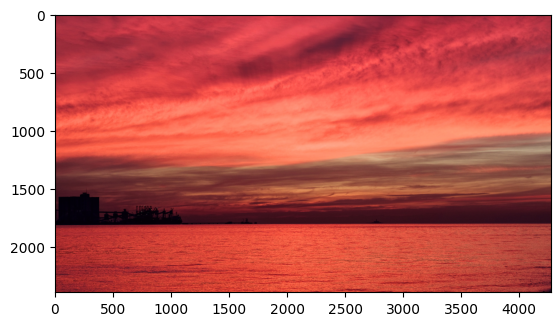

The image shows a sunset over the ocean. The sky is a gradient of pink, orange, and yellow. The sun is setting behind a large body of water, and there are some clouds in the sky. The water is calm and still, and there are some small waves breaking on the shore.



In [ ]:
print(generate("https://images.unsplash.com/photo-1439246854758-f686a415d9da", "Describe the image."))

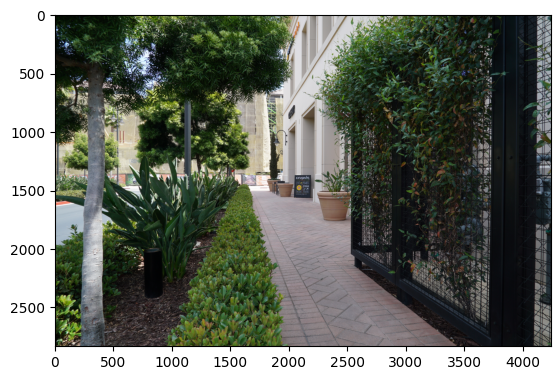

The shop is a yoga studio.


In [ ]:
print(generate(
    "https://huggingface.co/datasets/craigwu/vstar_bench/resolve/main/GPT4V-hard/0.JPG?download=true",
    "From the information on that advertising board, what is the type of this shop?"
    )
)

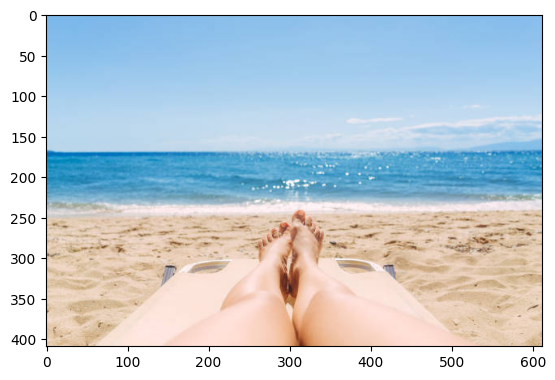

The photographer is resting on the beach, lying down on a beach towel, and enjoying the view of the ocean.


In [ ]:
print(generate(
    "https://media.istockphoto.com/id/1140860535/photo/beautiful-sea-view.jpg?s=612x612&w=0&k=20&c=wOlSk28kTLfIcaNX7LeF9IMfcKk_6Y2MXv1-Ppfo5_M=",
    "Where the photographer is resting?"
    )
)

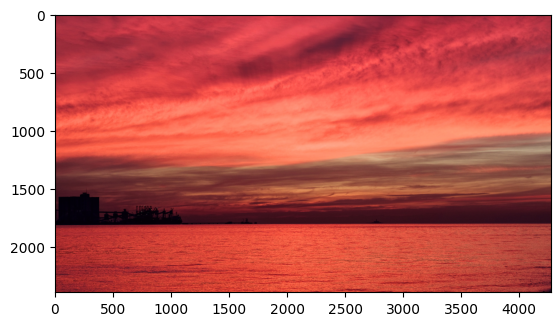

[
  {
    "color": "red",
    "description": "A large red ship is docked at a pier. The ship is surrounded by a large body of water.",
    "name": "ship",
    "position": "center",
    "size": "large",
    "type": "ship"
  },
  {
    "color": "orange",
    "description": "The sky is a bright orange color. The sun is setting and the sky is turning orange.",
    "name": "sky",
    "position": "top",
    "size": "large",
    "type": "sky"
  },
  {
    "color": "blue",
    "description": "The water is a deep blue color. The water is calm and there are no waves.",
    "name": "water",
    "position": "bottom",
    "size": "large",
    "type": "water"
  }
]


In [ ]:
import json

res = generate("https://images.unsplash.com/photo-1439246854758-f686a415d9da", """Generate a JSON description of the image.""")
json_res = json.loads(res)
print(json.dumps(json_res, indent=2))

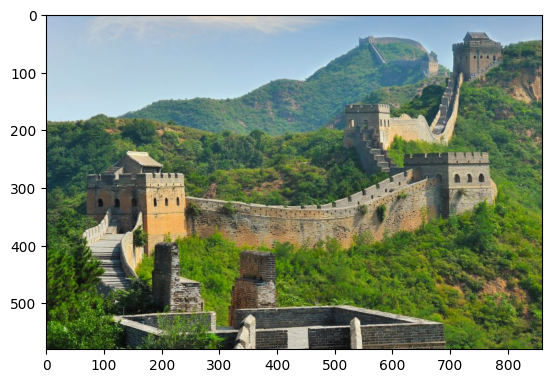

'The object in the image is the Great Wall of China.'

In [ ]:
generate("https://images.nationalgeographic.org/image/upload/t_edhub_resource_key_image/v1638892506/EducationHub/photos/the-great-wall-of-china.jpg", "What is the object in the image?")

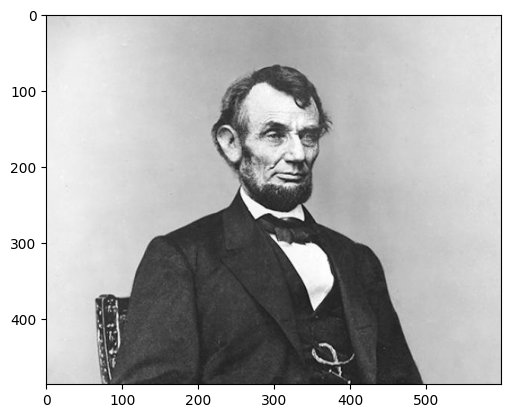

'Abraham Lincoln'

In [ ]:
generate("https://www.battlefields.org/sites/default/files/styles/squarish/public/thumbnails/image/Abraham%20Lincoln.jpg?h=d8c3850d&itok=7pJLksMv", "Who is it?")

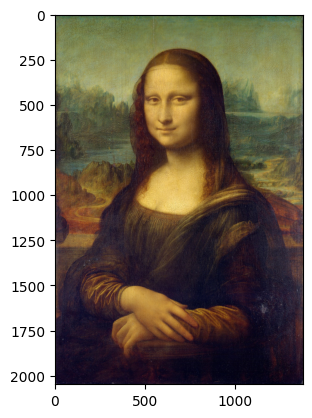

'Leonardo da Vinci'

In [ ]:
generate("https://t1.gstatic.com/licensed-image?q=tbn:ANd9GcQ-FvbbAq5IaJUhtwxXEwY0D-jiZju02ejnNHx_bQWL_27GF3srhwJgqusMAqKh3QqU", "Who is the author of this painting?")

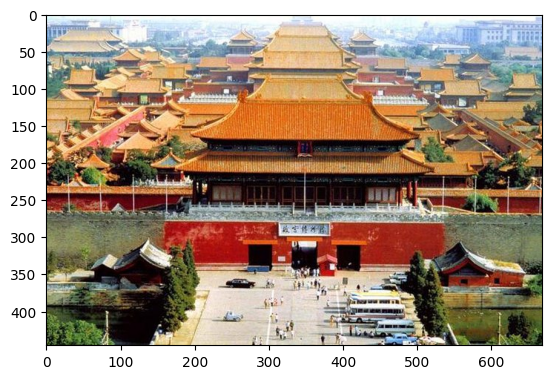

This is the Forbidden City, a complex of imperial palaces and gardens in Beijing, China. It was the home of the Chinese emperors from the Ming and Qing dynasties, and it is one of the most iconic landmarks in the world.


In [ ]:
print(
  generate(
    "https://media.tacdn.com/media/attractions-splice-spp-674x446/06/6b/67/97.jpg",
    "What is this place?"
  )
)

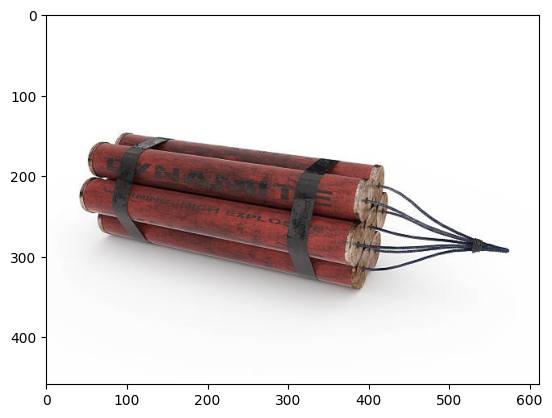

The side of the stick is labeled "Dynamite".


In [ ]:
print(
  generate(
    "https://media.istockphoto.com/id/545639598/photo/aged-dynamite-sticks.jpg?s=612x612&w=0&k=20&c=Jzs09FzYtNgOi2yuJwvog8bS2g0QLmnaogLU34LfYME=",
    "What is written on the side of the stick?"
  )
)

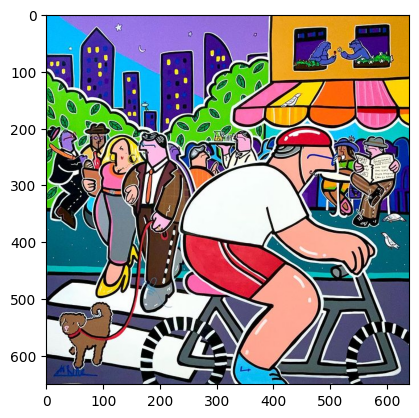

In [ ]:
print(
    generate(
        "https://scontent.cdninstagram.com/v/t39.30808-6/408251912_18400790653007674_2355768822851983428_n.jpg?stp=dst-jpg_e35_p640x640_sh0.08&efg=eyJ2ZW5jb2RlX3RhZyI6ImltYWdlX3VybGdlbi4xNDQweDE0NjQuc2RyIn0&_nc_ht=scontent.cdninstagram.com&_nc_cat=110&_nc_ohc=sVZJl39HPoMAX-XY1Dh&edm=APs17CUAAAAA&ccb=7-5&oh=00_AfC_yqmLI_yPvdJo34V4MVHnegHjwaxvy_EcGdLNJduUOg&oe=65B491BD&_nc_sid=10d13b",
        "Describe this image in details."
    )
)